# fitting experimental data with custom minimization routine 


**Attention:** use a kernel from an conda/mamba environment where fenicsx is installed

Doing the fit is relatively fast, but exploring the uncertainty space takes a long time!

The custum optimisation routine includes:

* use of weights for fitting
* use of two data-sets (with different lenght) for fitting
  * one should use normalized values for the two datasets to ensure that the sum of residuals for each dataset do not differ by two many orders of magnitude
   * we use normaliaztion with initial concertration 



In [1]:
import sys
import time
import os
import math
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy

Because the ADE_DG toolbox is (probably) not installed somewhere in the system we have to add the path to the location of the python code, either relative path of absolute path.

In [2]:
# import numerical toolbox ADE_DG for solving Advection-Diffusion-Equation specifically for trough-diffusion experiments
#import sys
sys.path.append("../sources") # include path to ../sources/ADE_DG1.py in path! -> this notebook is in ../notebooks/

# ADE_DG1.py must be in the path -> see path settings above
import ADE_DG
from ADE_DG import BoundaryCondition as BoundaryCondition # import BoundaryCondition in this way, otherwise it is not available ...

## Load experimental data

In principle one can load either text files or excel spreadsheets (requires openpyxl) with data. 
Best is to have data available in SI units, all other unit systems are not fail-save!
 * **times** in (s), relative to start of experiment
 * volumetric concentrations  (mol m⁻³) or (Bq m⁻³) or (kg m⁻³) 
 * all other measurements in the same unit system!




In [3]:
# load example dataset from Magick data
# define path to data directory
data_path="../../Magick-Data/Through diffusion data _Magic_2025/"
#data_path="/mnt/c/Users/xi_b/3D Objects/suduko/290720251/Magick-Data/Through diffusion data _Magic_2025/"
data_file_path="OPC26/Experimental data_OPC26.ods"
# data_file_path="ESD20/Experimental data_ESD20.ods"
# Load data sets from excel file ...sheet name needs to be known...
# we have the first two rows (0 and 1) for header, take first row for name (no.0) and skip second row (no.1)
Cusb=pd.read_excel(data_path+data_file_path,sheet_name='Cusb',header=0,skiprows=[1])
Jdsb=pd.read_excel(data_path+data_file_path,sheet_name='Jdsb',header=0,skiprows=[1])
Makk=pd.read_excel(data_path+data_file_path,sheet_name='Makk',header=0,skiprows=[1])

# next commands remove trailing whitespaces from columns names
# these are a constant source of trouble, 
#because they are not visible if you print them, but are assumed part of column names
Cusb.columns=Cusb.columns.str.strip()
Jdsb.columns=Jdsb.columns.str.strip()
Makk.columns=Makk.columns.str.strip()

# convert to correct units...in the dataset  the times are in Days! 
# (see skipped second row in excel spreadshee)
# 1Day = 1.0*24*3600
Day_to_sec=24.0*3600
Cusb.Time=Cusb.Time*Day_to_sec
Jdsb.Time=Jdsb.Time*Day_to_sec

Makk.Time=Makk.Time*Day_to_sec
Makk.Accu=Makk.Accu*Day_to_sec
Makk['U(Accu)']=Makk['U(Accu)']*Day_to_sec

In [4]:
print(Cusb.Cusb[0]-Cusb.Cusb)

0     0.000000e+00
1     2.052453e-08
2     6.199226e-08
3     3.834060e-08
4     4.978616e-08
5     7.262420e-08
6     5.556023e-08
7     6.685871e-08
8     4.859906e-08
9     9.150635e-08
10    6.045155e-08
11    5.113532e-08
12    4.651502e-08
Name: Cusb, dtype: float64


In [5]:
display(Cusb,Jdsb,Makk)
# meaning of names 
# Time in (s)
# Cusb concentration ustream boundary in (mol/m³)
# Vhigh/Vlow is volume in ml !!! -> needs transformation to m³

,Time,Cusb,U(Cusb),Vhigh
0,0.000000e+00,0.000002,1.185347e-07,19.9634
1,3.443400e+05,0.000002,1.172375e-07,19.9136
2,8.768400e+05,0.000002,1.146135e-07,19.8633
3,1.554240e+06,0.000002,1.161075e-07,19.8128
4,2.156400e+06,0.000002,1.153999e-07,19.7642
5,2.778720e+06,0.000002,1.139443e-07,19.7138
6,3.368340e+06,0.000002,1.150209e-07,19.6634
7,3.978420e+06,0.000002,1.143098e-07,19.6132
8,4.418100e+06,0.000002,1.154624e-07,19.5627
9,5.197200e+06,0.000002,1.127417e-07,19.5116


,Time,JL,U(JL),Vlow
0,4.290000e+04,0.000000e+00,4.307374e-17,10.021
1,1.307400e+05,0.000000e+00,3.997594e-17,9.653
2,2.158800e+05,0.000000e+00,4.955385e-17,9.980
3,3.002100e+05,0.000000e+00,4.464265e-17,9.936
4,4.749300e+05,3.302417e-16,2.926315e-17,9.985
5,6.885300e+05,3.935459e-16,4.126927e-17,9.843
6,8.241900e+05,5.088438e-16,5.816691e-17,9.896
7,1.084740e+06,5.639572e-16,4.190633e-17,9.941
8,1.344150e+06,6.978680e-16,7.189790e-17,9.868
9,1.474950e+06,6.941983e-16,5.871355e-17,9.975


,Time,Accu,U(Accu),Zeit_s,Acum,u(Acum),Acum_m,U(Acum_m)
0,8.580000e+04,0.000000e+00,6.269653e-12,8.580000e+04,0.000000,0.077645,0.000000e+00,7.249768e-17
1,1.756800e+05,0.000000e+00,8.744313e-12,1.756800e+05,0.000000,0.108292,0.000000e+00,1.011128e-16
2,2.560800e+05,0.000000e+00,1.105197e-11,2.560800e+05,0.000000,0.136870,0.000000e+00,1.277968e-16
3,3.443400e+05,0.000000e+00,1.291612e-11,3.443400e+05,0.000000,0.159957,0.000000e+00,1.493525e-16
4,6.055200e+05,1.463240e-10,1.830143e-11,6.055200e+05,1.812114,0.226650,1.691983e-15,2.116243e-16
5,7.715400e+05,2.571647e-10,2.168050e-11,7.715400e+05,3.184794,0.268497,2.973664e-15,2.506974e-16
6,8.768400e+05,3.480631e-10,2.404189e-11,8.768400e+05,4.310504,0.297741,4.024747e-15,2.780028e-16
7,1.292640e+06,7.458718e-10,3.810275e-11,1.292640e+06,9.237070,0.471874,8.624715e-15,4.405923e-16
8,1.395660e+06,8.678377e-10,4.012122e-11,1.395660e+06,10.747527,0.496872,1.003504e-14,4.639324e-16
9,1.554240e+06,1.054594e-09,4.311852e-11,1.554240e+06,13.060368,0.533991,1.219455e-14,4.985910e-16


In the next cell we have to insert some values for the diffusion cell:

The values are used (partly) for calculations, therefore units need to follwo SI..
Here I made a screenshot from spreadsheet for OPC26
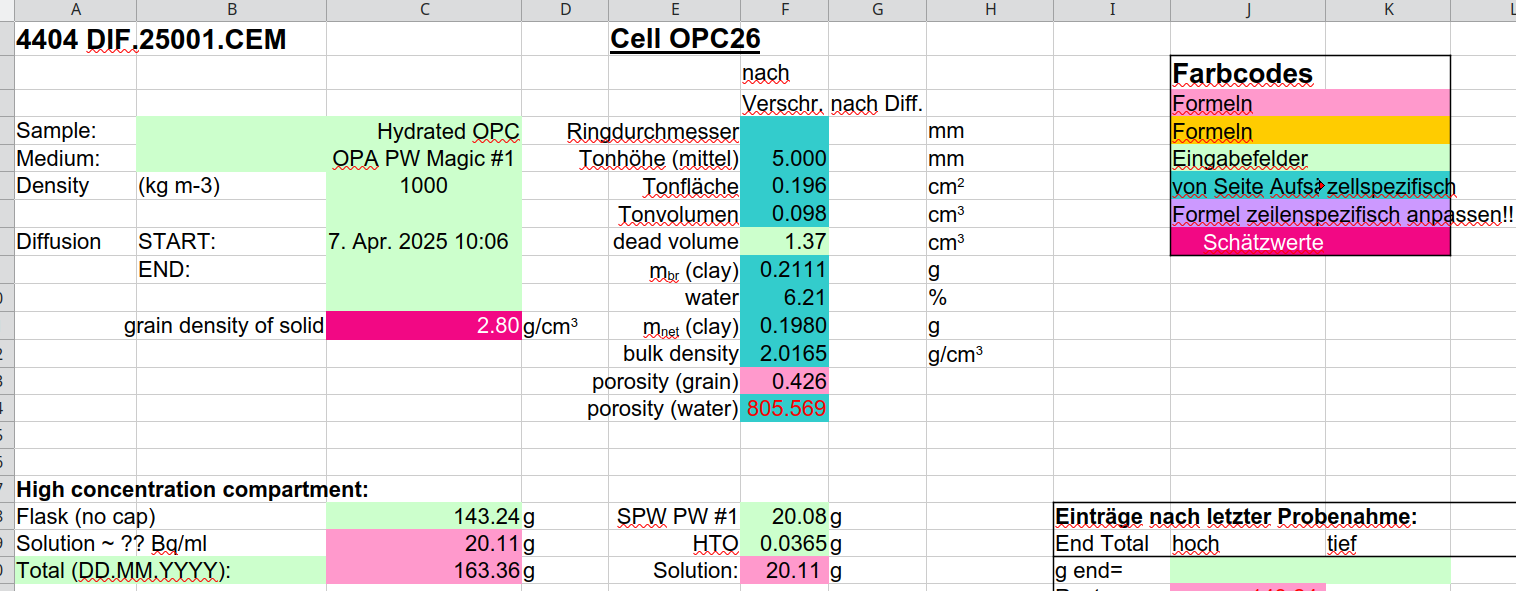
and here the right side with some uncertainties for measurements
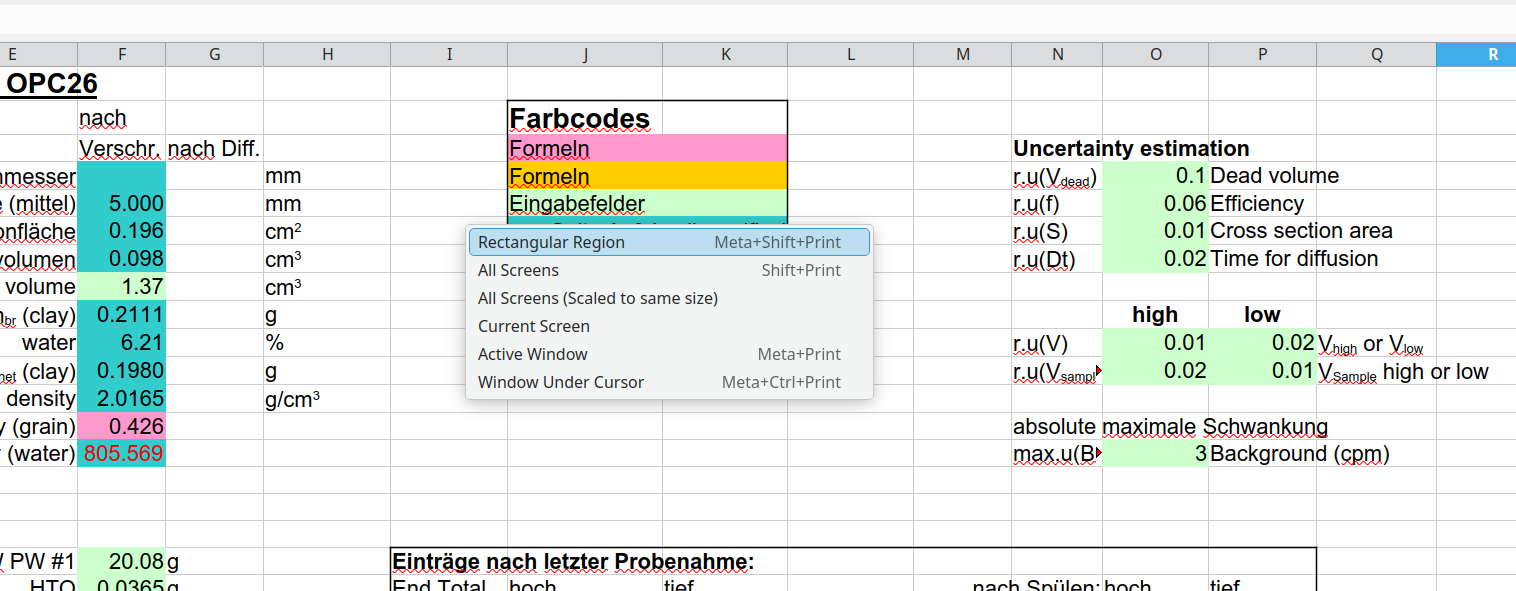

Experiment was conducted at 40°C
Temperature influence on reservoir volumes was not considered for estimation of experimental results..
Dead volume (missing filters) was not considered for reservoir volumes!



In [6]:
#sample thickness
sample_thickness=5e-3 # unit (m) = 5 mm
cross_section_area = 0.196e-4 # unit (m²) 0.196 cm * cm
# first attempt: we start with constant reservoir volumes
upstream_volume=Cusb.Vhigh[0] *1e-6 # needs to be in m³
downstream_volume=Jdsb.Vlow[0] * 1.0e-6 # needs to be in m³
upstream_concentration=Cusb['Cusb'][0]
normalization_factor=upstream_concentration
downstream_concentration=0.0

# we normalize for fitting the concentrations/fluxes by upstream_concentration to make it easier for the adaptive time stepping to control time step size!

# select fitting parameter for breakthrough
tdat=Jdsb.Time[:]   # to use only part of the values for fitting please use Jdsb.Time[0.20] for the first 20 Entries only
fdat=Jdsb.JL[:]  # downstram fluxes
fcdat=sc.integrate.cumulative_trapezoid(fdat,tdat,initial=0.0) # integrated downstream fluxes

# convenience array for plotting of uncertainty if not all datapoints are used for fitting
# and can be used as 1/fdatU for passing weights to the fitting routine!
fdatU=Jdsb['U(JL)'][:]

# data arrays for upstream severvoir
tudat=Cusb.Time[:]
cudat=Cusb.Cusb[:]
cudatU=Cusb['U(Cusb)'][:]

# to reset downstream concentration to "zero" we create an array of times 
t_down_rest=np.array(Makk.Time)
t_up_rest=np.array([])
#t_down_rest=[1.0e11]
print(t_down_rest)

[  85800.00000056  175680.00000059  256080.00000052  344340.00000029
  605520.00000046  771540.00000036  876840.00000036 1292640.00000036
 1395660.00000047 1554240.00000002 1811880.00000058 1987800.00000007
 2156400.00000021 2415480.00000045 2608620.00000011 2778720.00000011
 3020220.00000025 3199260.00000047 3368340.0000003  3626940.00000022
 3804840.0000005  3978420.00000053 4252440.00000044 4418100.00000042
 4837440.00000002 5025060.00000055 5197200.00000028 5609640.00000002
 5783700.00000035 6043320.00000046 6225840.00000008 6651540.0000003 ]


## Create and initialize function for numerical solver

One has to initialize and create a function that can be called from the fitting routine. 

The basic setup is based on mesh that was created with gmsh:

    * The dimensions of the mesh should be choosen that they represent the dimensions of the diffusion cell, filters, sample.
    * The different materials (sample, filter) and the influx (upstream) and outflux (downstream) boundaries have to be marked with "physical group Ids"
    * It is assumed the the upstream boundary is at x=0m and the downstream boundary at x = "lenght of sample + filters" in positive x-direction

The numerical solver is initialized via the ADE_DG call that reads the mesh from a file and requires a parameter that sets the "degree" of DG elements.

For the numerical setup the follwing parameters have to be defined and passed to the code:

    * material parameters
        - De and porosity/alpha for all materials (filter,sample)
        - Cross sectional area of the sample/filters
    * initial conditions
       - Initial concentrations everywhere in the domain
    * boundary conditions
        - position of the boundaries and their physical group id (marker no.)
        - initial concentrations in the Upstream and Downstream reservoirs
        - volume of the reservoirs
        - A flag that sets constant (boundary) concentrations in the reservoir: set_reservoir_boundaries(False), 
        or adjusts reservoir concentrations according to fluxes out of or into the reservoir: set_reservoir_boundaries(True)
        


In [7]:

# general definitions    
hour=3600.0
day=hour*24.0
year=day*365.25

# filename for gmsh file
mymesh_filename = "./gmsh/Magick1D.msh"
# define problem
# degree of desired FE is moved into ADE_DG
problem = ADE_DG.ADE_DG(mymesh_filename,deg=2)
problem.set_tol_adaptive(1.0e-12) #some default value for error tolerance used in adaptive time stepping loop
problem.set_logging_level("DEBUG")

# define everything once

# initial conditions
C0=0.0 # initial condition

# effective Diffusion for all marked materials
# we introduce default values
# markers can be found in gmsh geo file
De=1.0e-11
De_dict={
    5 : 1.0e-11,   #sample
}

# porosity/alpha ..this are default values
alpha=0.1
porosity_dict={
    5 : alpha    #sample
}
# if diffusion only the Darcy flux is 0.0 (zero) for all components
darcy_flux_vector = (0.0,0.0) # list  will work ...

# initial condition
C0=0.0
problem.set_initial_conditions(C0)

problem.set_darcy_flux(darcy_flux_vector)
problem.set_De(De_dict)
problem.set_porosity(porosity_dict)
# write materials in specific vtx file (do not use the same file as for time steps. this will overwrite file=
#problem.vtx_write_materials(filename_vtx_materials,t=0.0) 
problem.set_upstream_boundary(3,0.0) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration) # will be overwritten in flux_model function
problem.set_upstream_reservoir_volume(upstream_volume)
problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0) # will be overwritten in flux_model function
problem.set_downstream_reservoir_volume(downstream_volume)
problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
problem.set_upstream_reservoir_exchange_solution_times(t_up_rest)

problem.set_cross_section_area(cross_section_area) # 1 for comparison with analytical solution

problem.set_tol_adaptive(1.0e-7) # tolerance for adaptive time stepping

problem.set_logging_enabled() # enable logging
problem.set_logging_level("INFO")

#problem.set_logging_disabled() # disable

INFO:root:INFO: init with: ./gmsh/Magick1D.msh deg 2
INFO:root:INFO: mesh read! mesh dimension: 1 boundary dimension 0 geometry dimension: 2
INFO:root:Darcy flux is set to: (0.0, 0.0) for the whole domain.
INFO:root:INFO: De set via dictionary {5: 1e-11} default: 1.0e-11 
INFO:root:porosity set via dictionary {5: 0.1} default: 1.0
DEBUG:root:DEBUG: self.__downstream_exchange_times_done[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
DEBUG:root:DEBUG: self.__upstream_exchange_times_done[]


Info    : Reading './gmsh/Magick1D.msh'...
Info    : 3 entities
Info    : 18 nodes
Info    : 19 elements
Info    : Done reading './gmsh/Magick1D.msh'
set logging to level:  DEBUG
set logging to level:  INFO


## One manual run to test parameters

Before one does possibly time consuming fitting, it makes sense to once run the model to check input parameters and if the model runs at all.



In [8]:

t_real= max(tdat) #np.pow(t,10.0)

#### definitions for ADE-DG solutions that need to be re-set for multiple runs
# only reset everything that is changed during simulations or due to call -> alpha
C0=0.0 # initial concentration 
De =2.5e-12
alpha =0.45
# porosity
porosity_dict={
    5 : alpha  #sample   
}
De_dict={
    5 : De   #sample
}
u_old=problem.set_initial_conditions(C0/normalization_factor)
u_new=copy(u_old) # make a copy for u_new

problem.set_porosity(porosity_dict)
problem.set_De(De_dict)

problem.set_upstream_boundary(3,0.0/normalization_factor) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor)

problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0)

problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties

    
problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
problem.set_upstream_reservoir_exchange_solution_times(t_up_rest)

# Time stepping
t_end=max(tdat)
dt=1000.0
problem.set_dt(dt)
problem.set_T_end(t_end)
problem.set_tol_adaptive(1.0e-3)
#problem.set_dtmax=(t_end/10)
#problem.set_vtx_filename(filename_vtx, 10)
solution,data=problem.solve_adaptive_timesteps()
solution.x.array[:]=solution.x.array[:]*normalization_factor
data.iloc[:,2:]=data.iloc[:,2:]* normalization_factor
# for fitting integrated data!
#    flux=np.interp(t_real, data.time, np.abs(data.Downstream_flux_integr)) 

INFO:root:porosity set via dictionary {5: 0.45} default: 1.0
INFO:root:INFO: De set via dictionary {5: 2.5e-12} default: 1.0e-11 
INFO:root:INFO: Adaptive time loop starts with error tolerance: 0.001 update_reservoir_concentrations: True
INFO:root:INFO: t dt error est     0.0000 |  1000.0000 |  0.0007378
INFO:root:INFO: t dt error est  1000.0000 |  1104.4313 |  5.554e-05
INFO:root:INFO: t dt error est  2104.4313 |  4445.8442 |  0.0002047
INFO:root:INFO: t dt error est  6550.2754 |  9322.2004 |  0.0001280
INFO:root:INFO: t dt error est 15872.4759 | 24722.6933 |  0.0001813
INFO:root:INFO: t dt error est 40595.1691 | 45204.8309 |  0.0001200
INFO:root:INFO: t dt error est 85800.0000 | 89880.0000 |  0.0001291
INFO:root:INFO: t dt error est 175680.0000 | 80400.0000 |  2.601e-05
INFO:root:INFO: t dt error est 256080.0000 | 88260.0000 |  1.488e-05
INFO:root:INFO: t dt error est 344340.0000 | 261180.0000 |  8.639e-05
INFO:root:INFO: t dt error est 605520.0000 | 166020.0000 |  1.066e-05
INFO:roo

In [9]:
# add integrates downstream fluxes for fitting
dumy=np.array(data.Downstream_flux)*-1.0
dumx=np.array(data.time)
#display(dumx,dumy)
data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0)
#display(np.trapezoid(y=dumy,x=dumx))
test=np.interp(tdat, data.time, -1.0*(data.Downstream_flux))
display(data,test)

,time,dt,Upstream_concentration,Downstream_concentration,Upstream_flux,Downstream_flux,Downstream_flux_integr
row1,0.000000e+00,1000.000000,0.000002,-1.081804e-32,4.033699e-14,5.530999e-36,0.000000e+00
row1,1.000000e+03,1104.431260,0.000002,-1.008767e-29,2.850456e-14,4.664889e-33,2.335210e-30
row1,2.104431e+03,4445.844176,0.000002,-4.603330e-25,1.494841e-14,5.293749e-29,2.923782e-26
row1,6.550275e+03,9322.200416,0.000002,1.717647e-24,9.144702e-15,-1.194512e-28,-1.186170e-25
row1,1.587248e+04,24722.693294,0.000002,2.196784e-18,5.591831e-15,-4.543037e-23,-2.117562e-19
row1,4.059517e+04,45204.830854,0.000002,6.195025e-15,3.826609e-15,-7.004210e-20,-8.665880e-16
row1,8.580000e+04,89880.000000,0.000002,1.641086e-12,2.667554e-15,-9.335193e-18,-2.134476e-13
row1,1.756800e+05,80400.000000,0.000002,8.253243e-12,2.213579e-15,-5.248359e-17,-2.991584e-12
row1,2.560800e+05,88260.000000,0.000002,2.454316e-11,1.910128e-15,-1.421744e-16,-1.081684e-11
row1,3.443400e+05,261180.000000,0.000002,2.280980e-10,1.439889e-15,-4.465154e-16,-3.679572e-11


array([5.42438618e-19, 3.09093924e-17, 9.73290071e-17, 2.94344924e-16,
       5.19550258e-16, 6.27561147e-16, 7.44591335e-16, 8.37537723e-16,
       8.61063632e-16, 8.86834756e-16, 9.05474561e-16, 9.14584224e-16,
       9.21692074e-16, 9.26763158e-16, 9.29258861e-16, 9.31026100e-16,
       9.32257855e-16, 9.32898158e-16, 9.33390862e-16, 9.33734732e-16,
       9.33904000e-16, 9.34037348e-16, 9.34127415e-16, 9.34185025e-16,
       9.34225754e-16, 9.34237545e-16, 9.34247919e-16, 9.34255034e-16,
       9.34257430e-16, 9.34259082e-16, 9.34260191e-16, 9.34260805e-16])

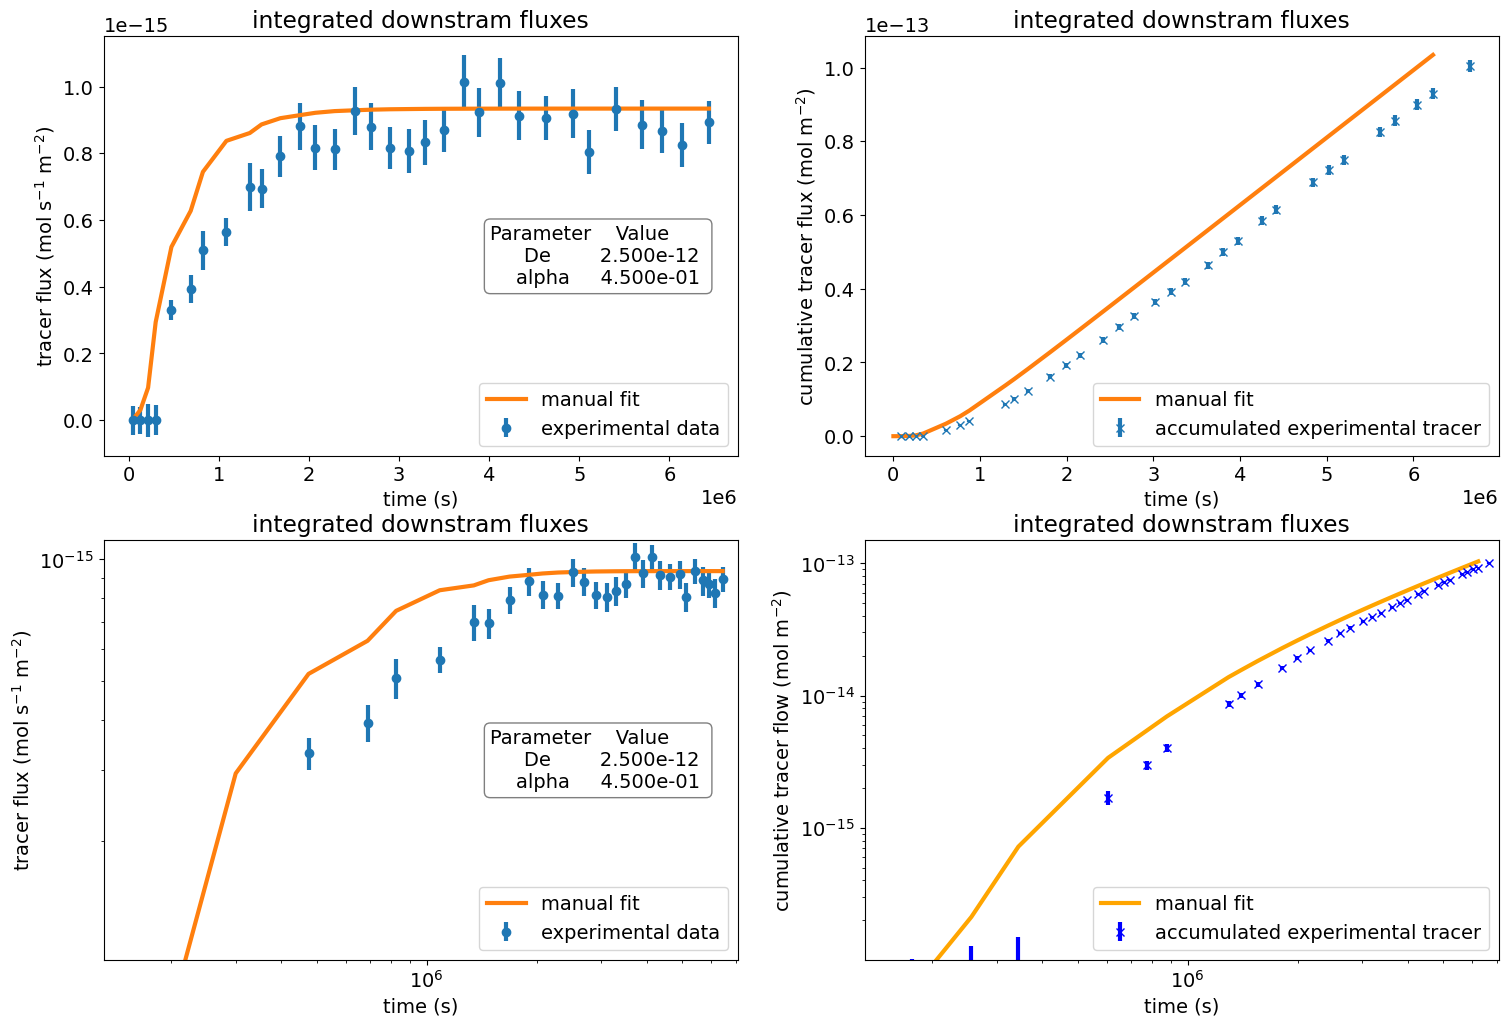

In [12]:
# We plot the fluxes ...aka breakthrough
# general plotting parameters
plt.rcParams["figure.figsize"] = [18, 12]
plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
plt.rcParams.update({'font.size': 14}) # update font size..default is 10 !
# create two subplots
fig, ax = plt.subplots(2,2)
#----- LEFT PLOT --------
ax[0,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data')

#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,0].plot(tdat, test, '-', label='manual fit')
#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[0,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,0].set_title('downstram fluxes')
ax[0,0].set_title('integrated downstram fluxes')
ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[0,0].legend( facecolor='white',loc="lower right")
#################### TOP ROW######################
#----- RIGHT PLOT --------
#ax[0,1].plot(tdat, fcdat*cross_section_area, 'o',label='accumulated experimental flux')
#ax[0,1].errorbar(Makk.Time, Makk.Accu*cross_section_area, yerr=Makk['U(Accu)']*cross_section_area,fmt='x',label='accumulated experimental data')
ax[0,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'],fmt='x',label='accumulated experimental tracer')

#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,1].plot(data.time, np.abs(data.Downstream_flux_integr)*cross_section_area, '-', label='manual fit')
#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
#ax[0,1].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,1].set_title('integrated downstram fluxes')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('cumulative tracer flux (mol m$^{-2}$)')
ax[0,1].legend( facecolor='white',loc="lower right")
########################Bottom ROW #########################
#----- LEFT PLOT --------

ax[1,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[1,0].plot(tdat, test, '-', label='manual fit')
#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[1,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[1,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,0].set_ylim((max(fdat)*1.0e-1,max(fdat)*1.1))
ax[1,0].set_title('downstram fluxes')
ax[1,0].set_title('integrated downstram fluxes')
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[1,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
#ax[1,1].loglog(tdat, test, '-', label='manual fit')
ax[1,1].loglog(data.time, np.abs(data.Downstream_flux_integr)*cross_section_area, '-', label='manual fit',color="orange")
ax[1,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'],fmt='x',label='accumulated experimental tracer',color='blue')

#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')

#add textbox with information
textstr = '\n'.join((
    'Parameter    Value      ',
    f'{'De   ':7s} {De:11.3e} ',
    f'{'alpha':7s} {alpha:11.3e} '))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
#ax[0,1].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[1,1].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,1].set_ylim((max(Makk.Acum_m)*1.0e-3,max(Makk.Acum_m)*1.5))
ax[1,1].set_title('integrated downstram fluxes')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('cumulative tracer flow (mol m$^{-2}$)')
ax[1,1].legend( facecolor='white',loc="lower right")


plt.show()

## Fitting with LMFIT

https://lmfit.github.io/lmfit-py/intro.html

The lmfit package provides simple tools to help you build complex fitting models for non-linear least-squares problems and apply these models to real data.

**Install lmfit-py with** **"mamba install lmfit"**

Why use lmfit?

While scipy offers an standard approach to optimization and curve fitting, LMFIT is a specialised tool that offers better support for advanced methods and diagnostic tools!


In [13]:

import lmfit as lmfit

#params = lmfit.Parameters()
#params.add('alpha', 0.6) # starting value for fit
#params.add('De', value=3.0e-12) # starting value for fit



## Fit downstream fluxes and upstream reservoir concentrations 

The basic idea of the fit is shown in this example:
https://lmfit.github.io/lmfit-py/examples/example_fit_multi_datasets.html#sphx-glr-examples-example-fit-multi-datasets-py

and as we have two datasets of different length we follow this example:
https://stackoverflow.com/questions/77047232/python-and-lmfit-fit-multiple-data-sets-with-different-lengths





In [14]:
# see here https://stackoverflow.com/questions/77047232/python-and-lmfit-fit-multiple-data-sets-with-different-lengths

def objective(params,tdat,fdat,fdatU,tudat,cudat,cudatU):
    alpha = params['alpha']
    De = params['De']
    #print("objective: called with alpha,De"+str(alpha)+str(De))

    # this can be moved out of the loop , at least in principle
    problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    problem.set_upstream_boundary(3,0.0) # should be "left boundary"
    problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
#    problem.set_tol_adaptive(1.0e-8)  
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha
    C0=0.0 # initial concentration 
    
    # porosity
    porosity_dict={
        5 : alpha  #sample   
    }
    # De
    De_dict={
        5 : De   #sample
    }
    u_old=problem.set_initial_conditions(C0/normalization_factor)
    
    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)
    
    problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
    problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor) 
    
    problem.set_downstream_reservoir_concentration(0.0/normalization_factor)
    
    # Time stepping
    t_end=max(tdat)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)

    solution,data=problem.solve_adaptive_timesteps()
    solution.x.array[:]=solution.x.array[:]*normalization_factor
    data.iloc[0:,2:]=data.iloc[:,2:]* normalization_factor
    #solution,data=problem.solve_timesteps() # fixed time stepping scheme! solution is fenics Function(V) object, while data is a pandas data frame
    # add integrates downstream fluxes for fitting
    data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0) # fluxes and concentrations need to be scaled back if used directly...

    ################## residual for fluxes ######################
    # for weighting we use the 1/variance !
    weight_flux=1.0/(fdatU*fdatU)
    # for time interpolation we can use np.interpolate
    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux))
    # resdiual fluxes are differences in y-values
    flux_res=(fdat-flux)*weight_flux
    ################### residual for concentrations ##############
    # for weighting we use the 1/variance !
    weight_uconc=1.0/(cudatU*cudatU)
    uconc=np.interp(tudat,data.time,data.Upstream_concentration)
    uconc_res=(cudat-uconc)*weight_uconc
    # for time interpolation we can use np.interpolate
#    concentration=np.interp(tudat, data.time, np.abs(data.Upstream_concentration))
#    uconc_res=(cudat-concentration)
# for fitting integrated data!
#    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux_integr)) 


    #print("Debug: solution, data, flux ",solution,data,flux)
    return np.concatenate((flux_res,uconc_res)) 

In [15]:
def flux_model(tdat,alpha,De):
    print("flux_model: called with alpha,De",alpha,De)

    # this can be moved out of the loop , at least in principle
    problem.set_update_reservoir_boundaries(True) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    problem.set_upstream_boundary(3,0.0) # should be "left boundary"
    problem.set_downstream_boundary(4,0.005) # should be "right  boundary"
#    problem.set_tol_adaptive(1.0e-8)  
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha
    C0=0.0 # initial concentration 
    
    # porosity
    porosity_dict={
        5 : alpha  #sample   
    }
    # De
    De_dict={
        5 : De   #sample
    }
    u_old=problem.set_initial_conditions(C0/normalization_factor)
    
    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)
    
    problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
    problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor)    
    problem.set_downstream_reservoir_concentration(0.0/normalization_factor)
    
    # Time stepping
    t_end=max(tdat)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)

    solution,data=problem.solve_adaptive_timesteps()
    #solution,data=problem.solve_timesteps() # fixed time stepping scheme! solution is fenics Function(V) object, while data is a pandas data frame
    # add integrates downstream fluxes for fitting
    data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0) # fluxes and concentrations need to be scaled back if used directly...

    solution.x.array[:]=solution.x.array[:]*normalization_factor
    data.iloc[:,2:]=data.iloc[0:,2:]* normalization_factor
    # for time interpolation we can use np.interpolate
    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux))

# for fitting integrated data!
#    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux_integr)) 


    #print("Debug: solution, data, flux ",solution,data,flux)
    return (flux) 

In [16]:
problem.set_logging_level("ERROR") # do not set to info, otherwise to much information is shown
# we can set number of time steppings via adaptive tolerance
problem.set_update_reservoir_boundaries(True)
problem.set_tol_adaptive(1.0e-3) # same value as for manual test

#problem.set_logging_disabled() # disable

params = lmfit.Parameters()
params.add('De', value=2.0e-12, min=1.0e-14, max=1.0e-9)
params.add('alpha', value=0.2, min=0.001)

#method = 'leastsq'

# create Minimizer
mini = lmfit.Minimizer(objective, params, fcn_args=(tdat, fdat,fdatU,tudat,cudat,cudatU), nan_policy='propagate')
print('####################### fit with Minimizer object for custom resdidual function  ###########################')
# first solve with Nelder-Mead algorithm
result_ademodel= mini.minimize(method='leastsq')


#result_ademodel = lmfit.minimize(objective, params, args=(tdat, fdat), method=method)
print("# Fit using sum of squares:\n")
lmfit.report_fit(result_ademodel)

set logging to level:  ERROR
####################### fit with Minimizer object for custom resdidual function  ###########################
# Fit using sum of squares:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 45
    # variables        = 2
    chi-square         = 1.2520e+34
    reduced chi-square = 2.9116e+32
    Akaike info crit   = 3365.76771
    Bayesian info crit = 3369.38103
[[Variables]]
    De:     2.3241e-12 +/- 4.5611e-14 (1.96%) (init = 2e-12)
    alpha:  0.58877518 +/- 0.02425579 (4.12%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(De, alpha) = +0.8553


In [17]:
print("########### model uncertainite using best fit #######################")
# here we calculate uncertainty values...this takes time!
confi,traces = lmfit.conf_interval(mini, result_ademodel, trace=True)

########### model uncertainite using best fit #######################


In [44]:
lmfit.report_ci(confi)
mtest=confi['De']
print(mtest[1][1])
print(mtest[5][1])


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 De   :  -0.00000  -0.00000  -0.00000   0.00000  +0.00000  +0.00000  +0.00000
 alpha:  -0.07465  -0.04905  -0.02445   0.58878  +0.02517  +0.05206  +0.08186
2.247534997053035e-12
2.401165362493791e-12


In [45]:
mtest

[(np.float64(0.9973002039367398), np.float64(2.1917716448141343e-12)),
 (np.float64(0.9544997361036416), np.float64(2.247534997053035e-12)),
 (np.float64(0.6826894921370859), np.float64(2.2715355461900894e-12)),
 (0.0, 2.3241035165535257e-12),
 (np.float64(0.6826894921370859), np.float64(2.3769032985727334e-12)),
 (np.float64(0.9544997361036416), np.float64(2.401165362493791e-12)),
 (np.float64(0.9973002039367398), np.float64(2.4571436354469844e-12))]

In [46]:
print(mtest[0][0])

0.9973002039367398


In [47]:
# run the model again
#### definitions for ADE-DG solutions that need to be re-set for multiple runs
# only reset everything that is changed during simulations or due to call -> alpha
DeU=confi['De']
print(DeU[1][1])
print(DeU[5][1])
alphaU=confi['alpha']

dummy=np.array(result_ademodel.params) # best fit parameters
De = DeU[3][1] #dummy[0]
alpha =alphaU[3][1] #dummy[1]

# for time interpolation we can use np.interpolate
flux=flux_model(tdat, alpha,De)

# simple way to get some uncertainity bands to the plot:
# we do it for +-2 sigma
# take the results of confi and run bounding cases with De_max, De_min, alpha_max, alpha_min
DeU=confi['De']
print(DeU[1][1])
print(DeU[5][1])
alphaU=confi['alpha']

flux1=flux_model(tdat, alphaU[1][1],DeU[1][1])
flux2=flux_model(tdat, alphaU[1][1],DeU[5][1])
flux3=flux_model(tdat, alphaU[5][1],DeU[1][1])
flux4=flux_model(tdat, alphaU[5][1],DeU[5][1])

2.247534997053035e-12
2.401165362493791e-12
flux_model: called with alpha,De 0.5887751801515687 2.3241035165535257e-12
2.247534997053035e-12
2.401165362493791e-12
flux_model: called with alpha,De 0.5397252079939555 2.247534997053035e-12
flux_model: called with alpha,De 0.5397252079939555 2.401165362493791e-12
flux_model: called with alpha,De 0.640834691326205 2.247534997053035e-12
flux_model: called with alpha,De 0.640834691326205 2.401165362493791e-12


In [48]:
#some more postprocessing is required....
flux_max=np.maximum.reduce([flux1,flux2,flux3,flux4])
flux_min=np.minimum.reduce([flux1,flux2,flux3,flux4])

In [49]:
# integrate downstream masses from best fit results!

#plt.fill_between(x, result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band')
# add integrates downstream fluxes for plotting
dumy=np.array(flux)
dumx=np.array(tdat)
#print(dumx,dumy)
best_fit_integr=sc.integrate.cumulative_trapezoid(y=dumy,x=dumx,initial=0.0)
# integrate upstream fluxes directly from model output
upstream_flux_integ= sc.integrate.cumulative_trapezoid(y=data.Upstream_flux,x=data.time,initial=0.0)
upstream_mass_integ=upstream_flux_integ*cross_section_area
upstream_conc_change=upstream_mass_integ/upstream_volume

display(upstream_conc_change)
print(data.Upstream_concentration[0]-data.Upstream_concentration,upstream_conc_change)


array([0.00000000e+00, 3.37942040e-11, 5.73528162e-11, 1.09935012e-10,
       1.77373112e-10, 2.91678399e-10, 4.35790231e-10, 6.51155341e-10,
       8.13910763e-10, 9.59055891e-10, 1.30819070e-09, 1.51147262e-09,
       1.62813330e-09, 2.05052959e-09, 2.15277572e-09, 2.30612633e-09,
       2.55051873e-09, 2.71579096e-09, 2.87298765e-09, 3.11322539e-09,
       3.29182003e-09, 3.44879528e-09, 3.67134413e-09, 3.83620082e-09,
       3.99178864e-09, 4.22964313e-09, 4.39322424e-09, 4.55279663e-09,
       4.80465844e-09, 4.95690251e-09, 5.34224200e-09, 5.51463275e-09,
       5.67278869e-09, 6.05169901e-09, 6.21159784e-09, 6.45008096e-09,
       6.61773275e-09])

row1    0.000000e+00
row1    3.090826e-11
row1    9.615680e-11
row1    1.798537e-10
row1    3.155823e-10
row1    4.854147e-10
row1    7.208101e-10
row1    8.955422e-10
row1    1.061061e-09
row1    1.430286e-09
row1    1.639444e-09
row1    1.764651e-09
row1    2.191566e-09
row1    2.295101e-09
row1    2.450506e-09
row1    2.696312e-09
row1    2.862221e-09
row1    3.020006e-09
row1    3.260660e-09
row1    3.439443e-09
row1    3.596567e-09
row1    3.819222e-09
row1    3.984133e-09
row1    4.139768e-09
row1    4.377661e-09
row1    4.541263e-09
row1    4.700851e-09
row1    4.952733e-09
row1    5.104985e-09
row1    5.490344e-09
row1    5.662743e-09
row1    5.820902e-09
row1    6.199828e-09
row1    6.359731e-09
row1    6.598223e-09
row1    6.765877e-09
row1    7.156893e-09
Name: Upstream_concentration, dtype: float64 [0.00000000e+00 3.37942040e-11 5.73528162e-11 1.09935012e-10
 1.77373112e-10 2.91678399e-10 4.35790231e-10 6.51155341e-10
 8.13910763e-10 9.59055891e-10 1.30819070e-09 1.51147262

### Plotting results

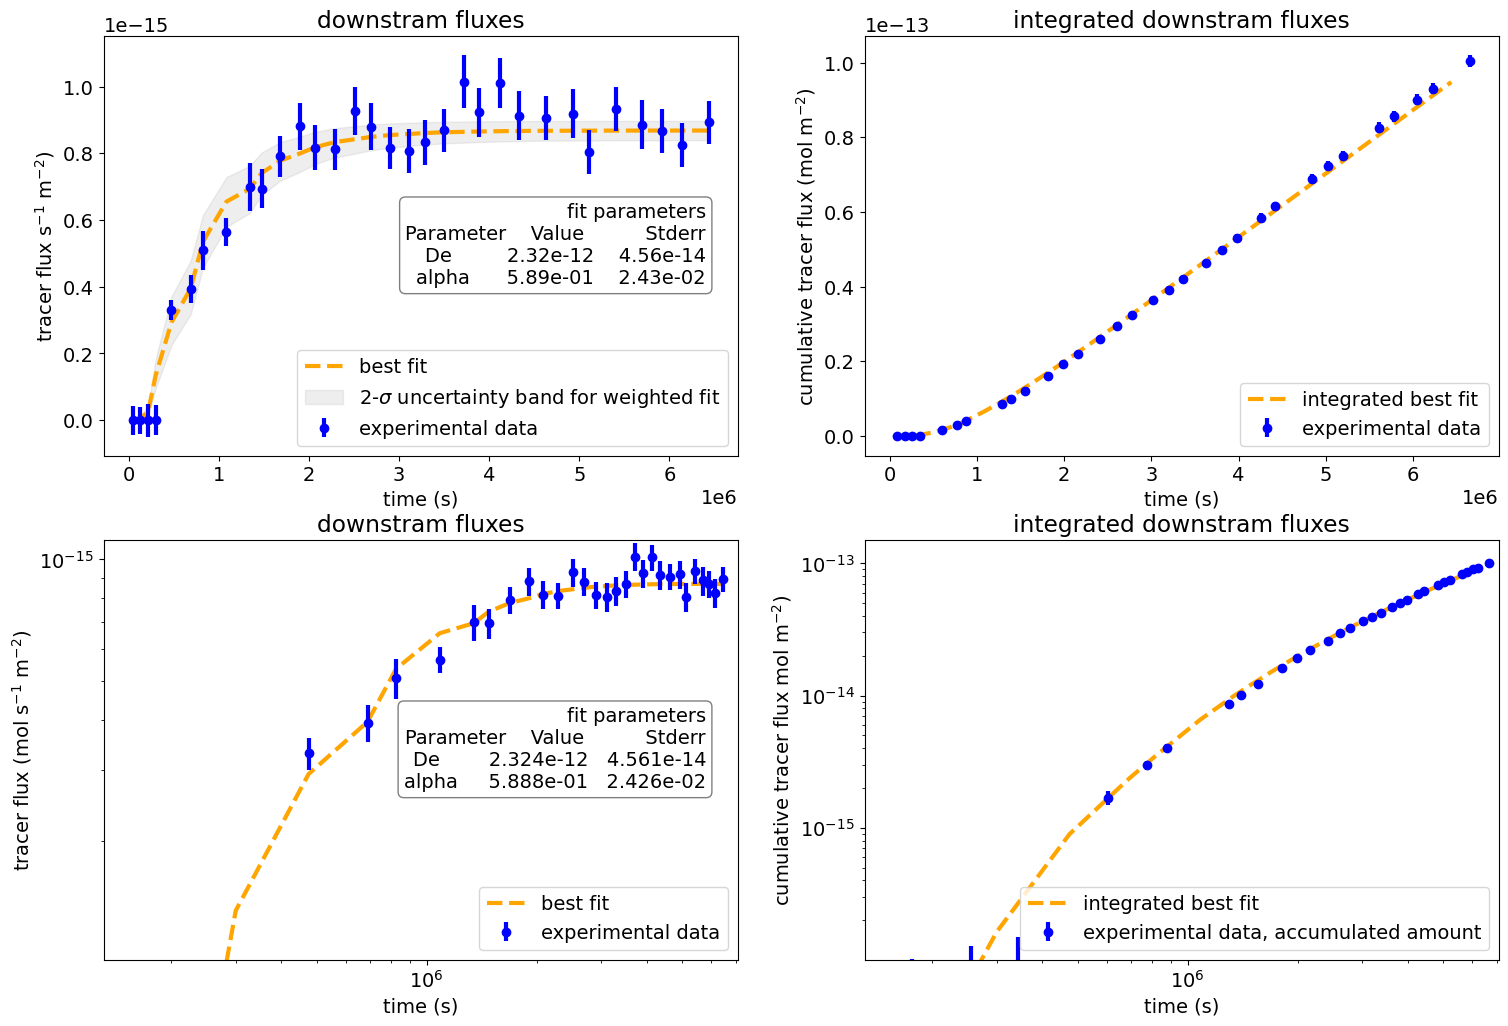

In [50]:
# We plot the fluxes ...aka breakthrough
# general plotting parameters
plt.rcParams["figure.figsize"] = [18, 12]
plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
plt.rcParams.update({'font.size': 14}) # update font size..default is 10 !
# create two subplots
fig, ax = plt.subplots(2,2)

########### UPPER ROW #############
#----- LEFT PLOT --------
ax[0,0].plot(tdat, flux, '--', label='best fit', color='orange')
ax[0,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data',color='blue')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,0].fill_between(tdat, flux_min, flux_max, color="#ABABAB",
                 label=r'2-$\sigma$ uncertainty band for weighted fit',alpha=0.2)
#--------add textbox with information----------
textstr = '\n'.join(("fit parameters",
    'Parameter    Value          Stderr',
    f'{'De   ':7s} {result_ademodel.params.get("De").value:11.2e} {result_ademodel.params.get("De").stderr:11.2e}',
    f'{'alpha':7s} {result_ademodel.params.get("alpha").value:11.2e} {result_ademodel.params.get("alpha").stderr:11.2e}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[0,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,0].set_title('downstram fluxes')

ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('tracer flux s$^{-1}$ m$^{-2}$)')
ax[0,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
ax[0,1].plot(tdat, best_fit_integr*cross_section_area, '--', label='integrated best fit', color='orange')
ax[0,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'], fmt='o',label='experimental data',color='blue')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')


#
ax[0,1].set_title('integrated downstram fluxes')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('cumulative tracer flux (mol m$^{-2}$)')
ax[0,1].legend( facecolor='white',loc="lower right")

########### LOWER ROW #############
#----- LEFT PLOT --------

ax[1,0].loglog(tdat, flux, '--', label='best fit', color='orange') # convenience function for log-log-plots ...axis can be also set to log axis via ax.set_xscale('log')
ax[1,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data',color='blue')
#ax[1,0].fill_between(tdat, dumy-dely, dumy+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band',alpha=0.2)
#--------add textbox with information----------
textstr = '\n'.join(("fit parameters",
    'Parameter    Value          Stderr',
    f'{'De   ':7s} {result_ademodel.params.get("De").value:11.3e} {result_ademodel.params.get("De").stderr:11.3e}',
    f'{'alpha':7s} {result_ademodel.params.get("alpha").value:11.3e} {result_ademodel.params.get("alpha").stderr:11.3e}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[1,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[1,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
# set bounds for axis based on experimental data
ax[1,0].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,0].set_ylim((max(fdat)*1.0e-1,max(fdat)*1.1))

ax[1,0].set_title('downstram fluxes')

ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('tracer flux (mol s$^{-1}$ m$^{-2}$)')
ax[1,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------a
ax[1,1].loglog(tdat, best_fit_integr*cross_section_area, '--', label='integrated best fit',color='orange')
ax[1,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'], fmt='o',label='experimental data, accumulated amount',color='blue') # convenience function for log-log-plots ...axis can be also set to log axis via ax.set_xscale('log')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')

#
# set bounds for axis based on experimental data
ax[1,1].set_xlim((tdat[1],max(tdat)*1.1))
ax[1,1].set_ylim((max(Makk.Acum_m)*1.0e-3,max(Makk.Acum_m)*1.5))

ax[1,1].set_title('integrated downstram fluxes')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('cumulative tracer flux mol m$^{-2}$)')
ax[1,1].legend( facecolor='white',loc="lower right")

fig.show()

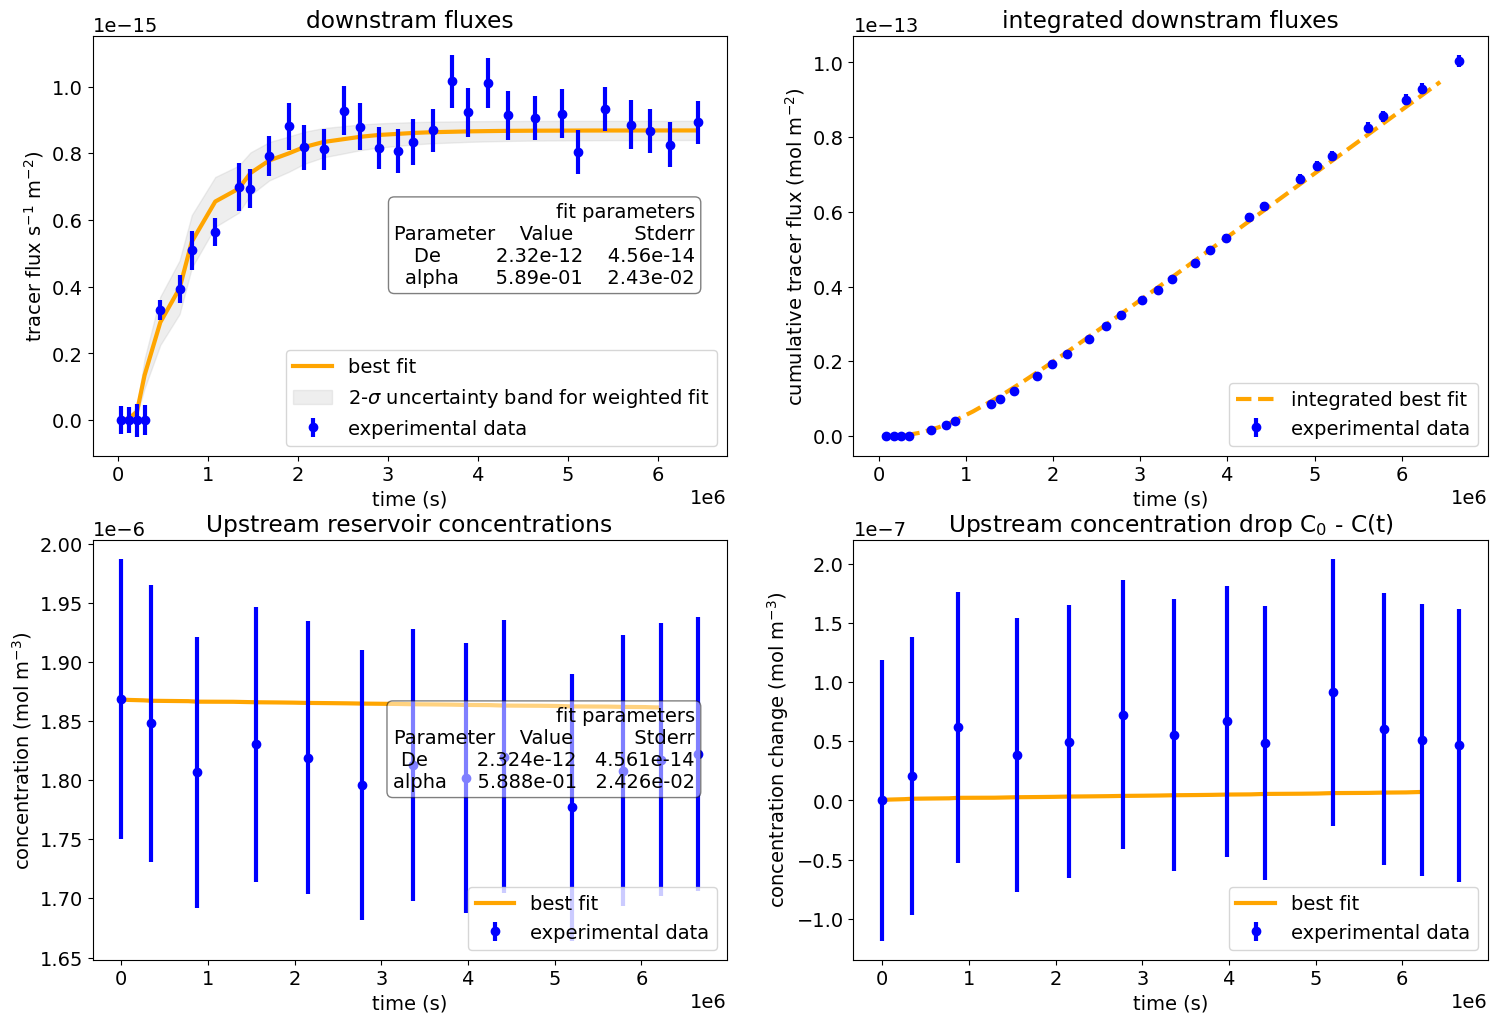

In [51]:
# We plot the fluxes ...aka breakthrough
# general plotting parameters
plt.rcParams["figure.figsize"] = [18, 12]
plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
plt.rcParams.update({'font.size': 14}) # update font size..default is 10 !
# create two subplots
fig, ax = plt.subplots(2,2)

########### UPPER ROW #############
#----- LEFT PLOT --------
ax[0,0].plot(tdat, flux, '-', label='best fit', color='orange')
ax[0,0].errorbar(tdat, fdat,yerr=fdatU,fmt= 'o',label='experimental data',color='blue')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')
ax[0,0].fill_between(tdat, flux_min, flux_max, color="#ABABAB",
                 label=r'2-$\sigma$ uncertainty band for weighted fit',alpha=0.2)
#--------add textbox with information----------
textstr = '\n'.join(("fit parameters",
    'Parameter    Value          Stderr',
    f'{'De   ':7s} {result_ademodel.params.get("De").value:11.2e} {result_ademodel.params.get("De").stderr:11.2e}',
    f'{'alpha':7s} {result_ademodel.params.get("alpha").value:11.2e} {result_ademodel.params.get("alpha").stderr:11.2e}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[0,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[0,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
ax[0,0].set_title('downstram fluxes')

ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('tracer flux s$^{-1}$ m$^{-2}$)')
ax[0,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
ax[0,1].plot(tdat, best_fit_integr*cross_section_area, '--', label='integrated best fit', color='orange')
ax[0,1].errorbar(Makk.Time, Makk.Acum_m, yerr=Makk['U(Acum_m)'], fmt='o',label='experimental data',color='blue')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')


#
ax[0,1].set_title('integrated downstram fluxes')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('cumulative tracer flux (mol m$^{-2}$)')
ax[0,1].legend( facecolor='white',loc="lower right")

########### LOWER ROW #############
#----- LEFT PLOT --------

ax[1,0].plot(data.time, data.Upstream_concentration, '-', label='best fit', color='orange') # convenience function for log-log-plots ...axis can be also set to log axis via ax.set_xscale('log')
ax[1,0].errorbar(tudat, cudat,yerr=cudatU,fmt= 'o',label='experimental data',color='blue')
#ax[1,0].fill_between(tdat, dumy-dely, dumy+dely, color="#ABABAB",
#                 label=r'3-$\sigma$ uncertainty band',alpha=0.2)
#--------add textbox with information----------
textstr = '\n'.join(("fit parameters",
    'Parameter    Value          Stderr',
    f'{'De   ':7s} {result_ademodel.params.get("De").value:11.3e} {result_ademodel.params.get("De").stderr:11.3e}',
    f'{'alpha':7s} {result_ademodel.params.get("alpha").value:11.3e} {result_ademodel.params.get("alpha").stderr:11.3e}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in lower right in axes coords
ax[1,0].text(0.95 ,0.4, textstr, fontsize=14,transform=ax[1,0].transAxes, horizontalalignment='right',verticalalignment='bottom',bbox=props)
#
# set bounds for axis based on experimental data
#ax[1,0].set_xlim((tdat[1],max(tdat)*1.1))
#ax[1,0].set_ylim(1.8e-6,2.0e-6)

ax[1,0].set_title('Upstream reservoir concentrations')

ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('concentration (mol m$^{-3}$)')
ax[1,0].legend( facecolor='white',loc="lower right")

#----- RIGHT PLOT --------
ax[1,1].plot(data.time, data.Upstream_concentration[0]-data.Upstream_concentration, '-', label='best fit',color='orange')
ax[1,1].errorbar(tudat, cudat[0]-cudat, yerr=cudatU, fmt='o',label='experimental data',color='blue') # convenience function for log-log-plots ...axis can be also set to log axis via ax.set_xscale('log')
#plt.plot(tdat, result_analytic.init_fit, '--', label='initial fit')

#
# set bounds for axis based on experimental data
#ax[1,1].set_xlim((tdat[1],max(tdat)*1.1))
#ax[1,1].set_ylim((max(Makk.Acum_m)*1.0e-3,max(Makk.Acum_m)*1.5))

ax[1,1].set_title('Upstream concentration drop C$_0$ - C(t)')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('concentration change (mol m$^{-3}$)')
ax[1,1].legend( facecolor='white',loc="lower right")

fig.show()

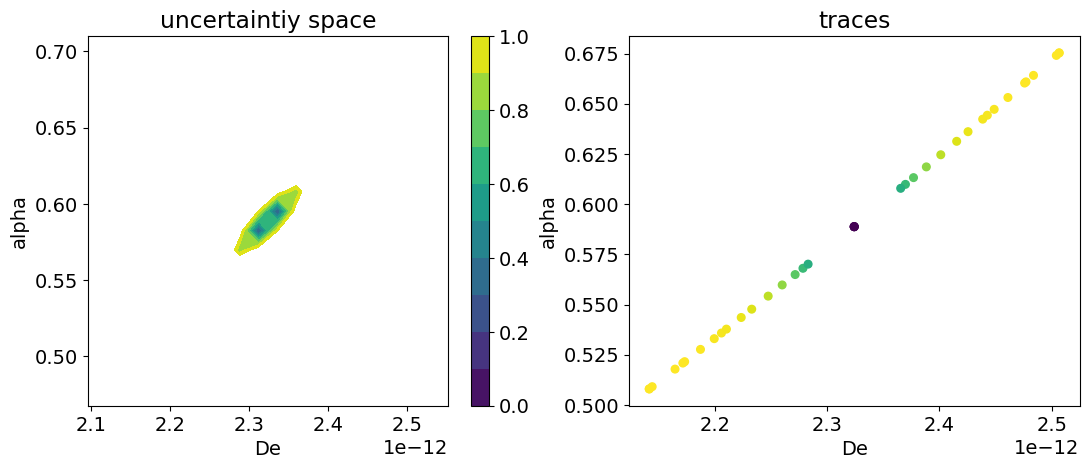

In [22]:
# plot confidence intervals (De vs alpha) ....this takes a whle, because x times y soloutions have to be obtained!
fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
cx, cy, grid = lmfit.conf_interval2d(mini, result_ademodel, 'De', 'alpha', 20, 20) # this command takes long time
ctp = axes[0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[0])

axes[0].set_title("uncertaintiy space")

axes[0].set_xlabel('De')
axes[0].set_ylabel('alpha')

axes[1].set_title("traces")
cx1, cy1, prob = traces['De']['De'], traces['De']['alpha'], traces['De']['prob']
axes[1].scatter(cx1, cy1, c=prob, s=30)

axes[1].set_xlabel('De')
axes[1].set_ylabel('alpha')

plt.show()